In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

import balance_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

In [4]:
quanta_h5 = "/mnt/Data/prerna_velocity/static_roi_waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
rec_dt = quantum_pack["rec_dt"]
target_rate_dt = 0.001  # 0.0001
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

vrate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.2,
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=target_rate_dt,
)
vrate = np.clip(vrate, 0.0, np.inf)

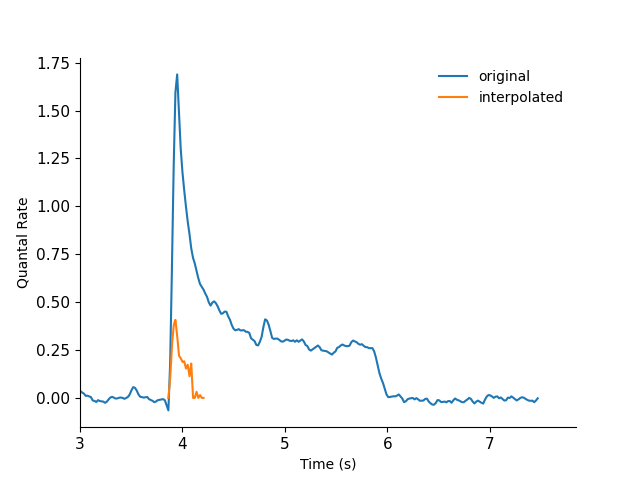

In [5]:
trans_rise = find_rise_bsln(bp_inputs["trans"], bsln_start=100, bsln_end=150, step=1) * rec_dt
rate_fig, rate_ax = plt.subplots(1)
rate_ax.plot(np.arange(len(bp_inputs["trans"])) * rec_dt, bp_inputs["trans"], label="original")
rate_ax.plot(np.arange(len(vrate)) * target_rate_dt + trans_rise, vrate, label="interpolated")
rate_ax.set_xlim(3)
rate_ax.set_xlabel("Time (s)")
rate_ax.set_ylabel("Quantal Rate")
rate_ax.legend(frameon=False)
clean_axes(rate_ax)

In [ ]:
model_path = os.path.join(base_path, "model_runs")
save_name = "test"
load_name = None
# load_name = "wip_releaser_test"
# load_name = "control"
# load_name = "ttx"
# load_name = "ds_ach"
# load_name = "non_ds_ach"
# load_name = "fully_non_ds_ach"

# load_name = "control_poisson"
# load_name = "plex2_share0p5_poisson"
# load_name = "control_0p54tau"
# load_name = "plex3_share0p5_0p54tau"

# load_name = "test_tmrho0p9"

model_config = configs.sac_mode_config(
    ttx=False,
    non_ds_ach=False,
    offset_ampa_ach=False,
    poisson_rates={"sac": vrate * 1., "glut": vrate * 1., "dt": target_rate_dt},
    plexus=0,
    plexus_share=0.5,
)

model_config["time_rho"] = 0.9

# model_config["synprops"]["E"]["weight"] = model_config["synprops"]["E"]["weight"] * 4
model_config["synprops"]["E"]["tau2"] = 0.54
# model_config["synprops"]["E"]["tau2"] = 0.4
# model_config["synprops"]["NMDA"]["pref_prob"] = 0.0
# model_config["synprops"]["NMDA"]["null_prob"] = 0.0
    
if load_name is None:
    from ei_balance_nogui import *
    os.makedirs(model_path, exist_ok=True)
    save_path = os.path.join(model_path, save_name) + ".h5"
    load_name = save_name
    t0 = time.time()
    exps.sacnet_run(
        save_path,
        model_config,
        n_nets=6,
        n_trials=3,
        rho_steps=[0.0, 1.0],
        # rho_steps=[1.0],
        pool_sz=6,
    )
    print("time:", time.time() - t0)

hdf = h5.File(os.path.join(model_path, load_name) + ".h5", "r")
d = Workspace(hdf, read_only=True)
        
rhos = list(d.keys())
idxs = list(d[rhos[0]].keys())
print("==keys==")
print("rhos:", rhos)
print("idxs:", idxs)
print("exp keys:", list(d[rhos[0]][idxs[0]].keys()))

sac net trials 1 to 6 (of 6)...
time before run: 0.12675118446350098
time before run: 0.14473628997802734
time before run:time before run:time before run:  0.2245349884033203
0.21594643592834473 
0.22057604789733887
time before run: 0.24611735343933105


In [ ]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            d.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [ ]:
metrics = ana.get_sac_metrics(d)

dir_labels = d[rhos[0]][idxs[0]]["params"]["dir_labels"][:]
tuning = ana.analyze_tree(d, dir_labels, pref=0, thresh=-56)
sac_thetas = ana.get_sac_thetas(d)
sac_deltas = ana.get_sac_deltas(sac_thetas)

In [ ]:
max_spikes = np.max([r["spikes"] for r in metrics.values()])
polar_fig = plt.figure(figsize=(7, 5))
n_cols = len(rhos)
polar_ax = [
    polar_plot(
        m,
        dir_labels,
        title="rho " + str(r),
        radius=max_spikes,
        net_shadows=False,
        save=False,
        fig=polar_fig,
        sub_loc=(1, n_cols, loc + 1),
        title_metrics=False,
    )
    for loc, (r, m) in enumerate(metrics.items())
]
polar_fig.tight_layout()

In [ ]:
violins = sac_rho_violins(metrics, dir_labels, figsize=(5, 8))

In [ ]:
scatter_fig = ds_scatter(tuning, figsize=(7, 4))
scatter_fig.tight_layout()

In [ ]:
dir_field_offsets = [11.0, 18.8, 37.8, 13.8, 0.8, 19.3, 16.0, 0.0]  # ms
rasters_fig = spike_rasters(
    d,
    dir_labels,
    rho=1.,
    bin_ms=50,
    offsets=dir_field_offsets,
    colour="black",
    spike_vmax=700,
    figsize=(8, 7),
)

In [ ]:
evol = time_evolution(d, dir_labels, kernel_var=45, figsize=(8, 7))

In [ ]:
rho = 1.0
if d[rho][0]["params"]["soma_Na"] == 0.0:  # TTX condition
    rec_locs = d[rho][0]["dendrites"]["locs"]
    syn_locs = d[rho][0]["syn_locs"]
    syn_rec_lookups = get_syn_rec_lookups(rec_locs, syn_locs)
    post_syn_avg_tuning = get_postsyn_avg_tuning(tuning, syn_rec_lookups)
    theta_diffs = plot_theta_diff_tuning_scatters(post_syn_avg_tuning, sac_deltas, rhos=[rho])
    theta_diff_bins = plot_theta_diff_vs_abs_theta(post_syn_avg_tuning, sac_deltas, rhos=[rho])

In [ ]:
rho = 0.0
net = 0

over_fig, over_ax = plt.subplots(1)
ana.plot_dends_overlay(
    over_fig,
    over_ax,
    d[rho][net]["syn_locs"],
    d[rho][net]["sac_net"]["wiring"]["bp_locs"],
    d[rho][net]["sac_net"]["wiring"]["probs"],
    dir_labels,
    stim_angle=0,
    n_syn=30,
    sac_thickness=2,
    sac_marker_size=200,
    syn_choice_seed=6,
)
#6 26 37
over_fig.tight_layout()

In [ ]:
conf = copy.deepcopy(model_config)
conf["seed"] = 4
angle_dist_fig, angle_dist_ax = ana.sac_angle_distribution(
    conf, n_nets=25, bins=[12], incl_yticks=True, figsize=(5, 4))

In [ ]:
# mr = MotionResponse(d[0.0][0], tree_k="Vm", figsize=(7, 7))
mr = MotionResponse(d[1.0][0], tree_k="Vm", figsize=(7, 7))

In [ ]:
close_button()

In [ ]:
rho = 1.0
net = 0
trial = 0

vm_pts = d[rho][net]["soma"]["Vm"].shape[-1]
vm_xaxis = np.linspace(0, vm_pts * d[rho][net]["params"]["dt"], vm_pts)

trial_vm_fig, trial_vm_ax = plt.subplots(1, len(dir_labels), sharex=True, sharey=True, figsize=(20, 4))
for i in range(len(dir_labels)):
    trial_vm_ax[i].plot(vm_xaxis[300:], d[rho][net]["soma"]["Vm"][trial, i, 300:], c="black")

clean_axes(trial_vm_ax, remove_spines=["left", "right", "top", "bottom"])

sizex = 200
sizey = 40
add_scalebar(
    trial_vm_ax[0], 
    matchx=False, 
    matchy=False, 
    sizex=sizex, 
    sizey=sizey, 
    labelx="%i ms" % sizex,
    labely="%i mV" % sizey,
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(165, 150),
    textprops={"fontsize": 18},
)

In [ ]:
# list(d[1.0][0]["soma"]["Vm"].shape

In [ ]:
list(d[0.00][0]["sac_net"]["wiring"].keys())

In [ ]:
list(d[0.00][0]["sac_net"]["wiring"]["thetas"])